<a href="https://colab.research.google.com/github/TalissaMoura/sounding_earth_with_vit/blob/main/notebooks/03_evaluate_results_for_vit_models_in_advance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Mount drive and call conda colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download code 
!git clone 

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://bucket-metadados-modelos.s3.us-east-1.amazonaws.com/envs/sounding_earth-4-Linux-x86_64.sh?response-content-disposition=inline&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPD%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXNhLWVhc3QtMSJIMEYCIQCaYTIzk87XIiwn0%2FNz1uidnoY%2FLwfWqw1wFjtIkqM7%2BgIhAOR%2FHI8hobrY6PbgaxHviPMucCRbs2LbWgTJ06Ko5qT%2FKu0CCKn%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQABoMMTEyNDk5MjY5Mzg5IgxN005g%2BQGVjJ%2F6cOIqwQKOi98w1alXNCFfuGAdmOW3cWbtt9CPEUJvUdfpM2Gum5Cu5meG255YWuM85yuPmkpvPRoX15a0AYdZAelBJBMDkXaYFWLrjT4Nqo3%2F8rN0tWhCAbiiMkzZLK%2BXZ5jO9M0YI%2BbYMC8zLr6k584F9dIMgRIhVkBaCJJ6ZGVKiCM7shc2Neuy1IH9t3H%2BbYjvUS3IwCPTyMmq8btbFk9atW5SuaePlntTbuQd%2FiDiN8%2B%2BOUNPDJqdGH6FBzvEA6a452x31vEn42%2FAVxFKm23huJdfiMp6wdbQ8YPAEz2Y6%2FS5ntj0UftmTKOBtyKJ8pD8piWU%2Fu8vTadTyert7vLCK5%2FO8zSIO%2BLtzlz31P2cOGl%2BhiML67it5rCpKguxMV2tvfrnJ6xlOFGmFPwKAyziEdc06faPmy%2BaG3syDIYgOZeo1MswjqPPrQY6sgK2dz2hSTThg0wbZV7tAfjI59FS5J%2FCIGQUiaE6o%2FrhNG9a4NqjsZoTlRsN6VyquFRMPXipjNB9Jy5u1ZXQRqHeBoh89xlLVafwn

In [ ]:
import condacolab
condacolab.check()

Login in wandb!

In [ ]:
import os
os.environ['WANDB__EXECUTABLE']='/usr/local/bin/python3.10'

In [ ]:
import wandb
#key = '998ffb924cd565faa75d442dad813b2cd96d1d0a'
#wandb.login()
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 2 - Making Imports

In [ ]:
!pwd

/content


In [ ]:
%cd /content/sounding_earth_with_vit

/content/test_advance


In [ ]:
!conda env update -n base -f ./sounding_earth_with_vit/environment_v4.yml

In [ ]:
import sys
import numpy as np
import pandas as pd
from collections import defaultdict
import json
from argparse import ArgumentParser
from pathlib import Path
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from einops import rearrange
import pickle
import re
#import wandb
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix

from lib import get_model, get_loss_function, FullModelWrapper, heatmap, annotate_heatmap
from config import cfg

In [ ]:
# Improve reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# For GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
import os
os.environ['WANDB__EXECUTABLE']='/usr/local/bin/python3.10'

In [ ]:
import wandb
#key = '998ffb924cd565faa75d442dad813b2cd96d1d0a'
#wandb.login()
!wandb login

wandb: Currently logged in as: talissamoura. Use `wandb login --relogin` to force relogin


In [ ]:
# Define run_id path to models and type of model

type_model = widgets.Text(
    value='',
    placeholder='Write model type',
    description='model type:',
    disabled=False
)


run_id = widgets.Text(
    value='',
    placeholder='Wandb run id',
    description='run_id:',
    disabled=False
)

model_path_str = widgets.Text(
    value='',
    placeholder='Type the dir',
    description='path_to_models:',
    disabled=False
)

## show widget
display(type_model)
display(run_id)
display(model_path_str)

Text(value='', description='model type:', placeholder='Write model type')

Text(value='', description='run_id:', placeholder='Wandb run id')

Text(value='', description='path_to_models:', placeholder='Type the dir')

In [ ]:
# CLOSE WIDGETS
run_id.close()
model_path_str.close()
# RUN ID NAME
run_id = run_id.value


# MODEL PATH
PATH_TO_MODELS = Path(model_path_str.value)


print(f"--- running metrics for {type_model.value} ---- ")

print(f"----- model run id {run_id} ---")

print(f"----- path to labels {PATH_TO_MODELS} ---- ")

--- running metrics for vit_base_32patch_latest ---- 
----- model run id test_advance_vit_base_32patch_224_ft_in21k_lr_v02_latest ---
----- path to labels logs/run_vit_base_patch32_224_ftnd_in21k-2 ---- 


# 3 - Download artifacts

In [ ]:
def download_valtrn_artifacts(name_run,type_artifact="train_data",name_dir="training_data"):
  if Path(f"./{name_dir}").is_dir():
    run = wandb.init()
    for data_mode in ["image","sound","mean","concat"]:
      for i in range(5):
        # download files
        dir_path = Path(f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
        dir_path.mkdir(parents=True,exist_ok=True)
        if dir_path.exists():
          try:
            artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}_{data_mode}_split{i+1}:latest"
            artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
            artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
          except ValueError:
            artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}_{data_mode}_split{i+1}:v0"
            artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
            artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
    run.finish()
  else:
    run = wandb.init()
    for data_mode in ["image","sound","mean","concat"]:
      for i in range(5):
        # create dir
        dir_path = Path(f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
        dir_path.mkdir(parents=True,exist_ok=True)
        # download files
        if dir_path.exists():
           try:
             artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}_{data_mode}_split{i+1}:latest"
             artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
             artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
           except ValueError:
             artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}_{data_mode}_split{i+1}:v0"
             artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
             artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}/{data_mode}/split{i+1}")
    run.finish()


In [ ]:
def download_test_data_artifacts(name_run,type_artifact="test_data",name_dir="test_data"):
  path_dir = Path(f"./{name_dir}/{name_run}")
  run = wandb.init()
  if path_dir.exists():
     try:
       artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}:latest"
       artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
       artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}")
     except ValueError:
       artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}:v0"
       artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
       artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}")
  else:
    path_dir.mkdir(parents=True,exist_ok=True)
    try:
       artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}:latest"
       artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
       artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}")
    except ValueError:
       artifact_name = f"talissamoura/teste_audiovisual_advance/{type_artifact}_for_run_{name_run}:v0"
       artifact = run.use_artifact(artifact_name, type=f'{type_artifact}')
       artifact_dir = artifact.download(root=f"./{name_dir}/{name_run}")
  run.finish()

In [ ]:
def download_models_artifacts(name_run,model_name_dir="lr_models",version="v0"):
  path_dir = Path(f"./lr_models/{name_run}")
  run = wandb.init()
  if path_dir.exists():
    try:
      artifact_name = f"talissamoura/teste_audiovisual_advance/{model_name_dir}:{version}"
      artifact = run.use_artifact(artifact_name, type="model")
      artifact_dir = artifact.download(root=f"./lr_models/{name_run}")
    except ValueError:
      artifact_name = f"talissamoura/teste_audiovisual_advance/{model_name_dir}:v0"
      artifact = run.use_artifact(artifact_name, type="model")
      artifact_dir = artifact.download(root=f"./lr_models/{name_run}")
  else:
    path_dir.mkdir(parents=True,exist_ok=True)
    try:
      artifact_name = f"talissamoura/teste_audiovisual_advance/{model_name_dir}:{version}"
      artifact = run.use_artifact(artifact_name, type="model")
      artifact_dir = artifact.download(root=f"./lr_models/{name_run}")
    except ValueError:
      artifact_name = f"talissamoura/teste_audiovisual_advance/{model_name_dir}:v0"
      artifact = run.use_artifact(artifact_name, type="model")
      artifact_dir = artifact.download(root=f"./lr_models/{name_run}")
  run.finish()

In [ ]:
def download_index_to_label_file(name_run):
  run = wandb.init()
  try:
    artifact = run.use_artifact(f'talissamoura/teste_audiovisual_advance/lbl_idx_for_run_{name_run}:latest', type='label_data')
    artifact_dir = artifact.download(root="./idx2lbl")
  except:
    artifact = run.use_artifact(f'talissamoura/teste_audiovisual_advance/lbl_idx_for_run_{name_run}:v0', type='label_data')
    artifact_dir = artifact.download(root="./idx2lbl")

In [ ]:
# print("---- downloading train data -----")
# download_valtrn_artifacts(name_run=run_id)

# print("--- downloading test data ---- ")

# download_test_data_artifacts(name_run=run_id)

print("--- downloading model data --")

download_models_artifacts(name_run=run_id,version="v11")

# print("---- downloading index to label file --- ")
# download_index_to_label_file(name_run=run_id)

--- downloading model data --


wandb:   20 of 20 files downloaded.  
wandb: Waiting for W&B process to finish... (success).
wandb: 🚀 View run honest-haze-58 at: https://wandb.ai/talissamoura/uncategorized/runs/f0g8u2s4
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240127_035956-f0g8u2s4/logs


In [ ]:
# LOAD IDX2LBL
with open("./idx2lbl/label_index.txt","r") as f:
  lines = f.readlines()
  lines = [l.replace("\n","") for l in lines]
  idx2lbl = {int(value[1]):value[0] for value in [l.split(",") for l in lines]}

# 4 - EDA

## 4.1 - Calculate models size in MB and number of parameters

In [ ]:
def load_model(path_to_model,path_cfg_file=None,return_inputs_size=True):

  dev = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

  if path_cfg_file != None:
    cfg.defrost()
    cfg.merge_from_file(path_cfg_file)
    cfg.freeze()

  if cfg.ImageEncoder == 'VisionTransformersEncoder':
    img_encoder = get_model(cfg.ImageEncoder,
        batch_size=cfg.BatchSize, output_dim=cfg.LatentDim,
        model_id=cfg.ModelName)
  else:
    img_encoder = get_model(cfg.ImageEncoder, reducer=cfg.ImageReducer,
        input_dim=3, output_dim=cfg.LatentDim, final_pool=False)

  if cfg.SoundEncoder == 'VisionTransformersEncoder':
    snd_encoder = get_model(cfg.SoundEncoder,
        batch_size=cfg.BatchSize, output_dim=cfg.LatentDim,
        model_id=cfg.ModelName)
  else:
    snd_encoder   = get_model(cfg.SoundEncoder, reducer=cfg.SoundReducer,
        input_dim=1, output_dim=cfg.LatentDim, final_pool=True)

  loss_function = get_loss_function(cfg.LossFunction)(*cfg.LossArg)
  model = FullModelWrapper(img_encoder, snd_encoder, loss_function).to(dev)
  model.eval()

  model.load_state_dict(torch.load(path_to_model / 'checkpoints/best.pt',map_location=dev))

  if return_inputs_size:
    if cfg.ImageEncoder == "VisionTransformersEncoder":
      img_encoder_input_size = (cfg.BatchSize,3,224,224)
    else:
      img_encoder_input_size = (cfg.BatchSize,3,384,384)

    if cfg.SoundEncoder == "VisionTransformersEncoder":
      snd_encoder_input_size = (cfg.BatchSize,3,224,224)
    else:
      snd_encoder_input_size = (cfg.BatchSize,1,128,128)

    return (model,img_encoder_input_size,snd_encoder_input_size)

  return model

In [ ]:
def model_count_params(model, input_size=(1,)):
    total_params = 0
    for param in model.parameters():
        total_params += torch.prod(torch.tensor(param.size()))

    # Account for the input tensor size (e.g., batch size and input features)
    total_params += torch.prod(torch.tensor(input_size))

    return total_params.item()

In [ ]:
models_path = {
    "ResNet18": Path("./models/TL-RN18"),
    "ResNet50": Path("./models/TL-RN50"),
    "vit_base_16patch": Path("./logs/run_vit_base_patch16_224_ft_in21k"),
    "vit_base_32patch": Path("./logs/run_vit_base_patch32_224_ftnd_in21k-2")
}


models_dict = {
    "ResNet18":{
        "config":None,
        "path_to_model": models_path["ResNet18"]
    },
    "ResNet50":{
        "config":Path("./models/TL-RN50/config.yml"),
        "path_to_model": models_path["ResNet50"]
    },
    "vit_base_16patch":{
        "config":Path("./logs/run_vit_base_patch16_224_ft_in21k/config.yml"),
        "path_to_model": models_path["vit_base_16patch"]
    },
    "vit_base_32patch":{
        "config":Path("./logs/run_vit_base_patch32_224_ftnd_in21k-2/config.yml"),
        "path_to_model": models_path["vit_base_32patch"]
    },

}

models = [(model_name,load_model(path_to_model=data["path_to_model"],path_cfg_file=data["config"],
          return_inputs_size=True))
          for model_name,data in models_dict.items()
          ]

In [ ]:
models_count_params_dict = dict()
for model_name,data in models:
  model = data[0]
  img_input_size = data[1]
  snd_input_size = data[2]
  img_encoder_cnt = model_count_params(model.img_encoder,input_size=img_input_size)
  snd_encoder_cnt = model_count_params(model.snd_encoder,input_size=snd_input_size)
  models_count_params_dict[model_name]=img_encoder_cnt+snd_encoder_cnt

for model_name,count in models_count_params_dict.items():
  print(f"Total num of parameters in {model_name}: {count}")

Total num of parameters in ResNet18: 38369872
Total num of parameters in ResNet50: 154459128
Total num of parameters in vit_base_16patch: 181366784
Total num of parameters in vit_base_32patch: 184651712


In [ ]:
def calculate_model_size(path_to_model):
  return path_to_model.stat().st_size * 1e-6

models_size = {model_name:calculate_model_size(path_to_model=Path(model_dir / "checkpoints/best.pt"))
              for model_name,model_dir in models_path.items()}

for model_name,size in models_size.items():
  print(f"Total size of the {model_name} model in MBs: {round(size,3)}")

Total size of the ResNet18 model in MBs: 94.941
Total size of the ResNet50 model in MBs: 148.512
Total size of the vit_base_16patch model in MBs: 687.047
Total size of the vit_base_32patch model in MBs: 700.187


In [ ]:
dict_compare_model_sizes = dict()
for model in models_path.keys():
  dict_compare_model_sizes[model] = {
      "Total parameters (M)": models_count_params_dict[model]*1e-6,
      "Total size (MB)": models_size[model]
  }

df_models_sizes = pd.DataFrame(data=dict_compare_model_sizes).T
df_models_sizes = df_models_sizes.round(3)
df_models_sizes = df_models_sizes.rename(axis="index",mapper=lambda strg:strg.replace("_"," "))
df_models_sizes

,Total parameters (M),Total size (MB)
ResNet18,38.370,94.941
ResNet50,154.459,148.512
vit base 16patch,181.367,687.047
vit base 32patch,184.652,700.187


In [ ]:
#SAVE IN LATEX

table_name = "compare_model_sizes.tex"

if Path(f"./tables/{type_model.value}").is_dir():
  save_at = f"./tables/{type_model.value}/{table_name}"
else:
  Path(f"./tables/{type_model.value}/").mkdir(parents=True)
  save_at = f"./tables/{type_model.value}/{table_name}"


df_models_sizes.style.format(precision=2)\
                     .format_index(axis=1,escape="latex")\
                     .format_index(axis=0,escape="latex")\
                     .to_latex(buf=save_at,hrules=True,clines="all;index",column_format="c c c",
                               label="tab:compare_model_sizes",caption="Comparação de tamanho dos modelos",
                               position_float="centering")

## 4.2 - Calculate scores of the models per class

In [ ]:
def calculate_avg_scores(run_name):
  test_data_path = f"./test_data/{run_id}"
  lr_models_path = f"./lr_models/{run_id}/all_lr_models"
  results = list()
  for data_mode in ["image","sound","mean","concat"]:
    for i in range(5):
      Z_img_test = np.load(Path(f"{test_data_path}/z_img_test.npy"))
      Z_snd_test = np.load(Path(f"{test_data_path}/z_snd_test.npy"))
      lbl_test = np.load(Path(f"{test_data_path}/lbl_test_data.npy"))
      Z_test = dict(
                image=Z_img_test,
                sound=Z_snd_test,
                mean=(Z_img_test + Z_snd_test) / 2,
                concat=np.concatenate([Z_img_test, Z_snd_test], axis=1)
            )[data_mode]

      with open(Path(f"./{lr_models_path}/split{i+1}_{data_mode}_lr_model.pkl",parents=True),"rb") as f:
        model = pickle.load(f)

      preds = model.predict(Z_test)
      res = dict(data=data_mode)
      precision, recall, fscore, _ = precision_recall_fscore_support(lbl_test, preds, average='weighted')
      res['precision'] = precision
      res['recall'] = recall
      res['fscore'] = fscore
      results.append(res)

  json_res = json.dumps(results)
  df = pd.read_json(json_res,orient="records")

  results_list = list()
  for data_mode, data in df.groupby(by='data').mean().T.items():
      metrics = data.to_dict()
      res_dict = {data_mode:{metric.title(): val for metric, val in metrics.items()}}
      results_list.append(res_dict)


  return results_list

In [ ]:
def calculate_avg_score_per_class(run_name,is_acending=True):
  test_data_path = f"./test_data/{run_name}"
  lr_models_path = f"./lr_models/{run_name}/all_lr_models"
  results = list()
  df_lists = list()
  for data_mode in ["image","sound","mean","concat"]:
    for i in range(5):
      Z_img_test = np.load(Path(f"{test_data_path}/z_img_test.npy"))
      Z_snd_test = np.load(Path(f"{test_data_path}/z_snd_test.npy"))
      lbl_test = np.load(Path(f"{test_data_path}/lbl_test_data.npy"))
      Z_test = dict(
                image=Z_img_test,
                sound=Z_snd_test,
                mean=(Z_img_test + Z_snd_test) / 2,
                concat=np.concatenate([Z_img_test, Z_snd_test], axis=1)
            )[data_mode]

      with open(Path(f"./{lr_models_path}/split{i+1}_{data_mode}_lr_model.pkl",parents=True),"rb") as f:
        model = pickle.load(f)

      preds = model.predict(Z_test)

      df = pd.DataFrame(data={"predict_values":preds,"real_values":lbl_test})
      df["mode"]= data_mode
      df["score"] = df["real_values"].eq(df["predict_values"]).astype("int")
      df_lists.append(df)

  final_df = pd.concat(df_lists,ignore_index=True)
  class_series = final_df.groupby(by=["mode","real_values"])["score"].mean().sort_values(ascending=is_acending)
  for data_mode in ["image","sound","mean","concat"]:
    results.append({data_mode:class_series[data_mode].to_dict()})

  return results

In [ ]:
def calculate_stats_per_class(run_name):
  test_data_path = f"./test_data/{run_name}"
  lr_models_path = f"./lr_models/{run_name}/all_lr_models"
  df_lists = list()
  for data_mode in ["image","sound","mean","concat"]:
    for i in range(5):
      Z_img_test = np.load(Path(f"{test_data_path}/z_img_test.npy"))
      Z_snd_test = np.load(Path(f"{test_data_path}/z_snd_test.npy"))
      lbl_test = np.load(Path(f"{test_data_path}/lbl_test_data.npy"))
      Z_test = dict(
                image=Z_img_test,
                sound=Z_snd_test,
                mean=(Z_img_test + Z_snd_test) / 2,
                concat=np.concatenate([Z_img_test, Z_snd_test], axis=1)
            )[data_mode]

      with open(Path(f"./{lr_models_path}/split{i+1}_{data_mode}_lr_model.pkl",parents=True),"rb") as f:
        model = pickle.load(f)

      preds = model.predict(Z_test)

      df = pd.DataFrame(data={"predict_values":preds,"real_values":lbl_test})
      df["mode"]= data_mode
      df["score"] = df["real_values"].eq(df["predict_values"]).astype("int")
      df_lists.append(df)

  final_df = pd.concat(df_lists,ignore_index=True)
  class_series = final_df.groupby(by=["mode","real_values"])["score"].describe()

  return class_series

In [ ]:
!pwd

/content/test_advance


In [ ]:
def calculate_confusion_matrix_per_class(run_name):
  test_data_path = f"./test_data/{run_name}"
  lr_models_path = f"./lr_models/{run_name}/all_lr_models"
  conf_matrix_arrs = defaultdict(list)
  for data_mode in ["image","sound","mean","concat"]:
    for i in range(5):
      Z_img_test = np.load(Path(f"{test_data_path}/z_img_test.npy"))
      Z_snd_test = np.load(Path(f"{test_data_path}/z_snd_test.npy"))
      lbl_test = np.load(Path(f"{test_data_path}/lbl_test_data.npy"))
      Z_test = dict(
                image=Z_img_test,
                sound=Z_snd_test,
                mean=(Z_img_test + Z_snd_test) / 2,
                concat=np.concatenate([Z_img_test, Z_snd_test], axis=1)
            )[data_mode]

      with open(Path(f"./{lr_models_path}/split{i+1}_{data_mode}_lr_model.pkl",parents=True),"rb") as f:
        model = pickle.load(f)

      preds = model.predict(Z_test)
      cf_matrix = confusion_matrix(lbl_test,preds)
      conf_matrix_arrs[data_mode].append(cf_matrix)



  final_dict = {}
  for data_mode,data in conf_matrix_arrs.items():
    for mtx in data:
      if data_mode not in final_dict.keys():
        final_dict[data_mode] = mtx
      else:
        final_dict[data_mode]+=mtx


  return final_dict

In [ ]:
print(f"--- calculate overall scores for advance with {type_model.value} and {run_id} ---")

vit_model_res_list = calculate_avg_scores(run_name=run_id)

df_result_vit = pd.concat(list(map(lambda data: pd.DataFrame.from_dict(data).T,vit_model_res_list)))

df_result_vit.index.name = "mode"

df_result_vit = df_result_vit.reset_index()
df_result_vit["model name"] = type_model.value.replace("_"," ")
df_result_vit = df_result_vit.copy().set_index(["model name","mode"])
df_result_vit

--- calculate overall scores for advance with vit_base_32patch_latest and test_advance_vit_base_32patch_224_ft_in21k_lr_v02_latest ---


Fscore  Precision    Recall
model name              mode                                 
vit base 32patch latest concat  0.860267   0.862615  0.861675
                        image   0.811761   0.816473  0.814975
                        mean    0.786833   0.793342  0.790739
                        sound   0.425588   0.446364  0.428966

In [ ]:
#SAVE IN LATEX

table_name = f"avg_scores_for_{type_model.value}.tex"

if Path(f"./tables/{type_model.value}").is_dir():
  save_at = f"./tables/{type_model.value}/{table_name}"
else:
  Path(f"./tables/{type_model.value}").mkdir()
  save_at = f"./tables/{type_model.value}/{table_name}"


df_result_vit.style.format(precision=2)\
                     .format_index(axis=1,escape="latex")\
                     .format_index(axis=0,escape="latex")\
                     .to_latex(buf=save_at,hrules=True,clines="all;index",column_format="c c c c c c c c c c",
                               position_float="centering")

In [ ]:
print("--- calculate mean scores per class ---")
mean_per_class = calculate_avg_score_per_class(run_name=run_id)
mean_per_class

--- calculate mean scores per class ---


[{'image': {11: 0.45625,
   5: 0.5866666666666667,
   1: 0.6604651162790698,
   7: 0.7070422535211267,
   8: 0.7121951219512195,
   12: 0.7615384615384615,
   3: 0.7651162790697674,
   6: 0.7784313725490196,
   2: 0.8321428571428572,
   0: 0.8486486486486486,
   10: 0.8592592592592593,
   4: 0.884393063583815,
   9: 0.9563981042654028}},
 {'sound': {12: 0.21153846153846154,
   1: 0.29767441860465116,
   7: 0.3154929577464789,
   10: 0.3333333333333333,
   3: 0.34651162790697676,
   5: 0.35333333333333333,
   0: 0.3837837837837838,
   6: 0.396078431372549,
   11: 0.40625,
   8: 0.45365853658536587,
   2: 0.4785714285714286,
   4: 0.5317919075144508,
   9: 0.5535545023696683}},
 {'mean': {1: 0.5116279069767442,
   5: 0.5266666666666666,
   12: 0.6,
   11: 0.625,
   8: 0.6829268292682927,
   7: 0.7408450704225352,
   3: 0.7511627906976744,
   6: 0.7666666666666667,
   0: 0.8,
   2: 0.8035714285714286,
   10: 0.8271604938271605,
   4: 0.8531791907514451,
   9: 0.95260663507109}},
 {'concat

In [ ]:
print("---- calculate stats per class ---")

df_stats_per_class = calculate_stats_per_class(run_name=run_id)

treated_df_stats_per_class = df_stats_per_class.reset_index()
treated_df_stats_per_class["real_values"] = treated_df_stats_per_class["real_values"].map(idx2lbl)
treated_df_stats_per_class = treated_df_stats_per_class.rename(axis="columns",mapper={"real_values":"class name"})

df_final_stats_per_class = treated_df_stats_per_class.copy().set_index(["mode","class name"])
df_final_stats_per_class

---- calculate stats per class ---


count      mean       std  min   25%  50%  75%  max
mode   class name                                                             
concat airport             185.0  0.886486  0.318080  0.0  1.00  1.0  1.0  1.0
       beach               215.0  0.581395  0.494482  0.0  0.00  1.0  1.0  1.0
       bridge              280.0  0.846429  0.361183  0.0  1.00  1.0  1.0  1.0
       farmland            430.0  0.883721  0.320933  0.0  1.00  1.0  1.0  1.0
       forest              865.0  0.886705  0.317136  0.0  1.00  1.0  1.0  1.0
       grassland           150.0  0.746667  0.436377  0.0  0.25  1.0  1.0  1.0
       harbour             510.0  0.850980  0.356457  0.0  1.00  1.0  1.0  1.0
       lake                355.0  0.808451  0.394076  0.0  1.00  1.0  1.0  1.0
       orchard             205.0  0.814634  0.389545  0.0  1.00  1.0  1.0  1.0
       residential        1055.0  0.955450  0.206411  0.0  1.00  1.0  1.0  1.0
       sparse shrub land   405.0  0.903704  0.295362  0.0  1.00  1.0  1.0  1.0
       sports land         160.0  0.793750  0.405882  0.0  1.00  1.0  1.0  1.0
       train station       260.0  0.765385  0.424575  0.0  1.00  1.0  1.0  1.0
image  airport             185.0  0.848649  0.359364  0.0  1.00  1.0  1.0  1.0
       beach               215.0  0.660465  0.474657  0.0  0.00  1.0  1.0  1.0
       bridge              280.0  0.832143  0.374409  0.0  1.00  1.0  1.0  1.0
       farmland            430.0  0.765116  0.424420  0.0  1.00  1.0  1.0  1.0
       forest              865.0  0.884393  0.319938  0.0  1.00  1.0  1.0  1.0
       grassland           150.0  0.586667  0.494081  0.0  0.00  1.0  1.0  1.0
       harbour             510.0  0.778431  0.415710  0.0  1.00  1.0  1.0  1.0
       lake                355.0  0.707042  0.455762  0.0  0.00  1.0  1.0  1.0
       orchard             205.0  0.712195  0.453848  0.0  0.00  1.0  1.0  1.0
       residential        1055.0  0.956398  0.204305  0.0  1.00  1.0  1.0  1.0
       sparse shrub land   405.0  0.859259  0.348184  0.0  1.00  1.0  1.0  1.0
       sports land         160.0  0.456250  0.499646  0.0  0.00  0.0  1.0  1.0
       train station       260.0  0.761538  0.426965  0.0  1.00  1.0  1.0  1.0
mean   airport             185.0  0.800000  0.401085  0.0  1.00  1.0  1.0  1.0
       beach               215.0  0.511628  0.501031  0.0  0.00  1.0  1.0  1.0
       bridge              280.0  0.803571  0.398008  0.0  1.00  1.0  1.0  1.0
       farmland            430.0  0.751163  0.432843  0.0  1.00  1.0  1.0  1.0
       forest              865.0  0.853179  0.354132  0.0  1.00  1.0  1.0  1.0
       grassland           150.0  0.526667  0.500961  0.0  0.00  1.0  1.0  1.0
       harbour             510.0  0.766667  0.423368  0.0  1.00  1.0  1.0  1.0
       lake                355.0  0.740845  0.438789  0.0  0.00  1.0  1.0  1.0
       orchard             205.0  0.682927  0.466475  0.0  0.00  1.0  1.0  1.0
       residential        1055.0  0.952607  0.212580  0.0  1.00  1.0  1.0  1.0
       sparse shrub land   405.0  0.827160  0.378576  0.0  1.00  1.0  1.0  1.0
       sports land         160.0  0.625000  0.485643  0.0  0.00  1.0  1.0  1.0
       train station       260.0  0.600000  0.490843  0.0  0.00  1.0  1.0  1.0
sound  airport             185.0  0.383784  0.487626  0.0  0.00  0.0  1.0  1.0
       beach               215.0  0.297674  0.458303  0.0  0.00  0.0  1.0  1.0
       bridge              280.0  0.478571  0.500435  0.0  0.00  0.0  1.0  1.0
       farmland            430.0  0.346512  0.476413  0.0  0.00  0.0  1.0  1.0
       forest              865.0  0.531792  0.499277  0.0  0.00  1.0  1.0  1.0
       grassland           150.0  0.353333  0.479606  0.0  0.00  0.0  1.0  1.0
       harbour             510.0  0.396078  0.489561  0.0  0.00  0.0  1.0  1.0
       lake                355.0  0.315493  0.465368  0.0  0.00  0.0  1.0  1.0
       orchard             205.0  0.453659  0.499067  0.0  0.00  0.0  1.0  1.0
       residential        1055.0  0.553555  0.497359  0.0  0.00  1.0  1.0  1.

In [ ]:
#SAVE IN LATEX

table_name = "compare_class_stats.tex"

if Path(f"./tables/{type_model.value}").is_dir():
  save_at = f"./tables/{type_model.value}/{table_name}"
else:
  Path(f"./tables/{type_model.value}").mkdir()
  save_at = f"./tables/{type_model.value}/{table_name}"


df_final_stats_per_class.style.format(precision=2)\
                     .format_index(axis=1,escape="latex")\
                     .format_index(axis=0,escape="latex")\
                     .to_latex(buf=save_at,hrules=True,clines="all;index",column_format="c c c c c c c c c c",
                               label=f"tab:compare_class_stats_{type_model.value}",caption=f"Estatisticas por classes para {type_model.value}",
                               position_float="centering")

## 4.3 - Plots to visualize the model results per class

--- plot overall scores per class for every kind of model ---


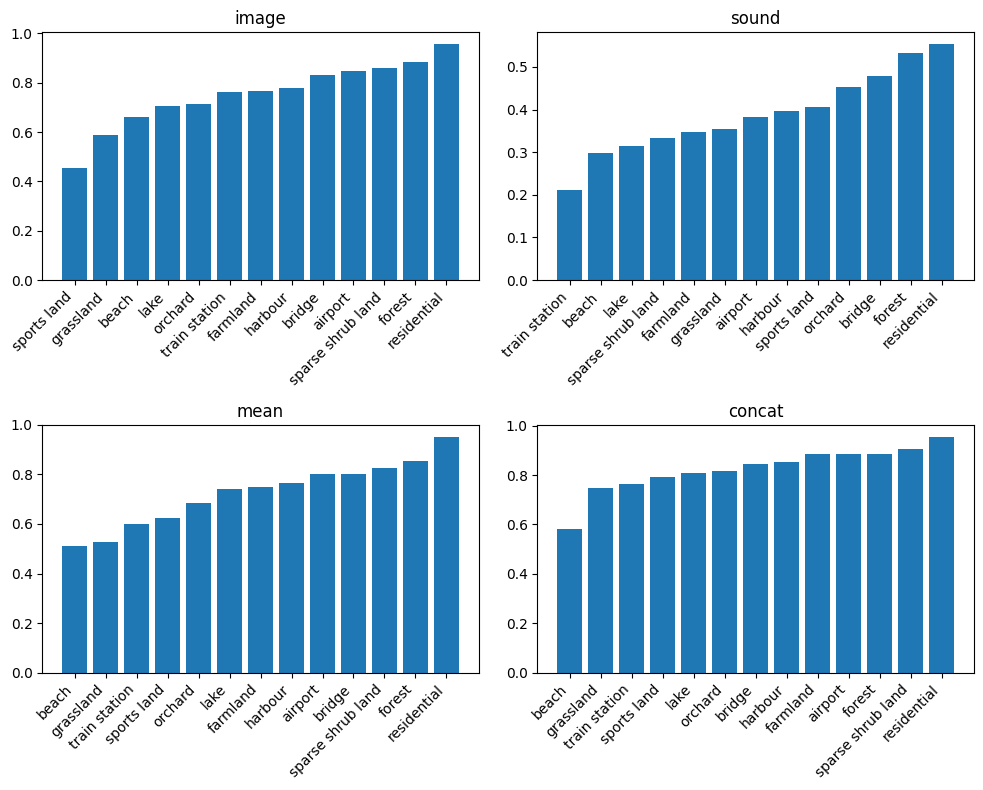

In [ ]:
# plots!

print("--- plot overall scores per class for every kind of model ---")

fig = plt.figure(figsize=(10,8))
for idx in range(4):
  title,all_values = list(mean_per_class[idx].items())[0]
  mean_per_label = {idx2lbl[idx]:value for idx,value in all_values.items()}
  plt.subplot(2,2,idx+1)
  bars=plt.bar(x=list(mean_per_label.keys()),height=list(mean_per_label.values()),label=mean_per_label.keys())
  plt.title(title)
  plt.xticks(rotation=45,ha="right")


plt.tight_layout()

In [ ]:
# SAVE FIGURE

figure_name = "compare_model_scores_per_class.png"

if Path(f"figures/{type_model.value}").is_dir():
  save_at = f"./figures/{type_model.value}/{figure_name}"
else:
  Path(f"figures/{type_model.value}").mkdir(parents=True)
  save_at = f"./figures/{type_model.value}/{figure_name}"


fig.savefig(save_at)

#clears the plt
plt.show()


Bons embeddings de imagem --- gerar resultados melhores quando se junta imagem e som

os embeddings de imagem conseguiram ser melhor construidos com o vit_base_patch16.

Os embeddings de airport,residential e forest são os melhores aprendidos tanto em imagem quanto som e por isso quando utilizados para classificação em conjunto geram bons resultados.

Contudo para classes ruins de classificação apenas com imagens resulta em uma classificação ruim quando utilizada em conjunto com dados de audio. Isso se dá pois nesse caso, o modelo não conseguiu aprender tão bem as representações dos dados de áudio.



In [ ]:
print("---- calculate confusuion matrix ---")
dict_cf = calculate_confusion_matrix_per_class(run_name=run_id)

---- calculate confusuion matrix ---


--- plot confusion matrix to classes image and sound ---


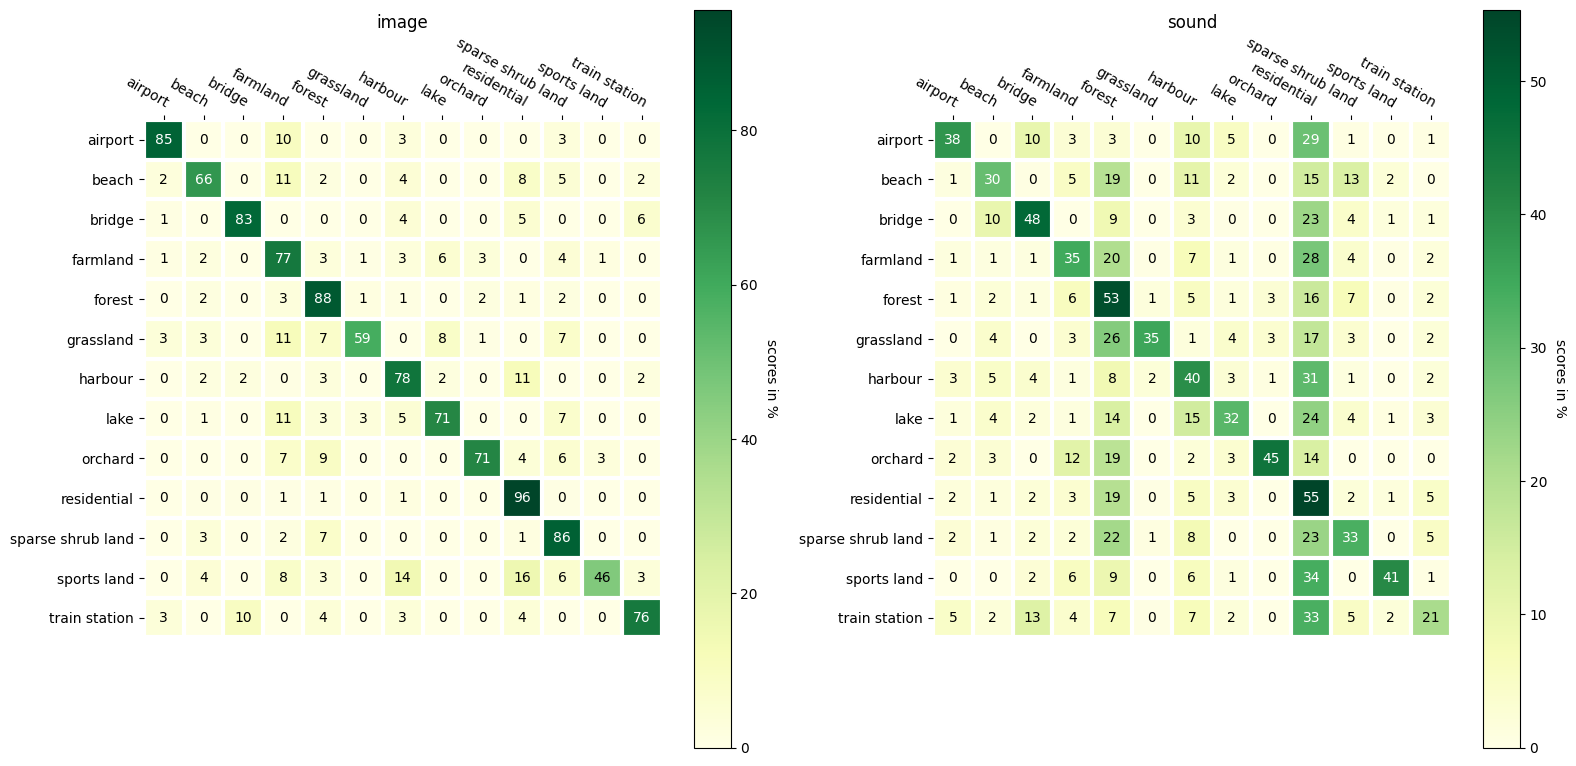

In [ ]:
print("--- plot confusion matrix to classes image and sound ---")

fig = plt.figure(figsize=(16,8))
for idx in range(2):
  title,cf_values = list(dict_cf.items())[idx]
  count_arr = np.sum(cf_values,axis=1)[:,np.newaxis]
  percentual_cf_values = np.divide(cf_values,count_arr)*100
  ax = plt.subplot(1,2,idx+1)
  im, cbar = heatmap(percentual_cf_values,idx2lbl.values(),idx2lbl.values(), ax=ax,
                   cmap="YlGn", cbarlabel="scores in %")

  texts = annotate_heatmap(im,valfmt="{x:.0f}")
  plt.title(title)

plt.tight_layout()

In [ ]:
# SAVE FIGURE

figure_name = "confusion_matrix_sound_image.png"

if Path(f"figures/{type_model.value}").is_dir():
  save_at = f"./figures/{type_model.value}/{figure_name}"
else:
  Path(f"figures/{type_model.value}").mkdir(parents=True)
  save_at = f"./figures/{type_model.value}/{figure_name}"


fig.savefig(save_at)

#clears the plt
plt.show()

--- plot confusion matrix to classes concat and mean ---


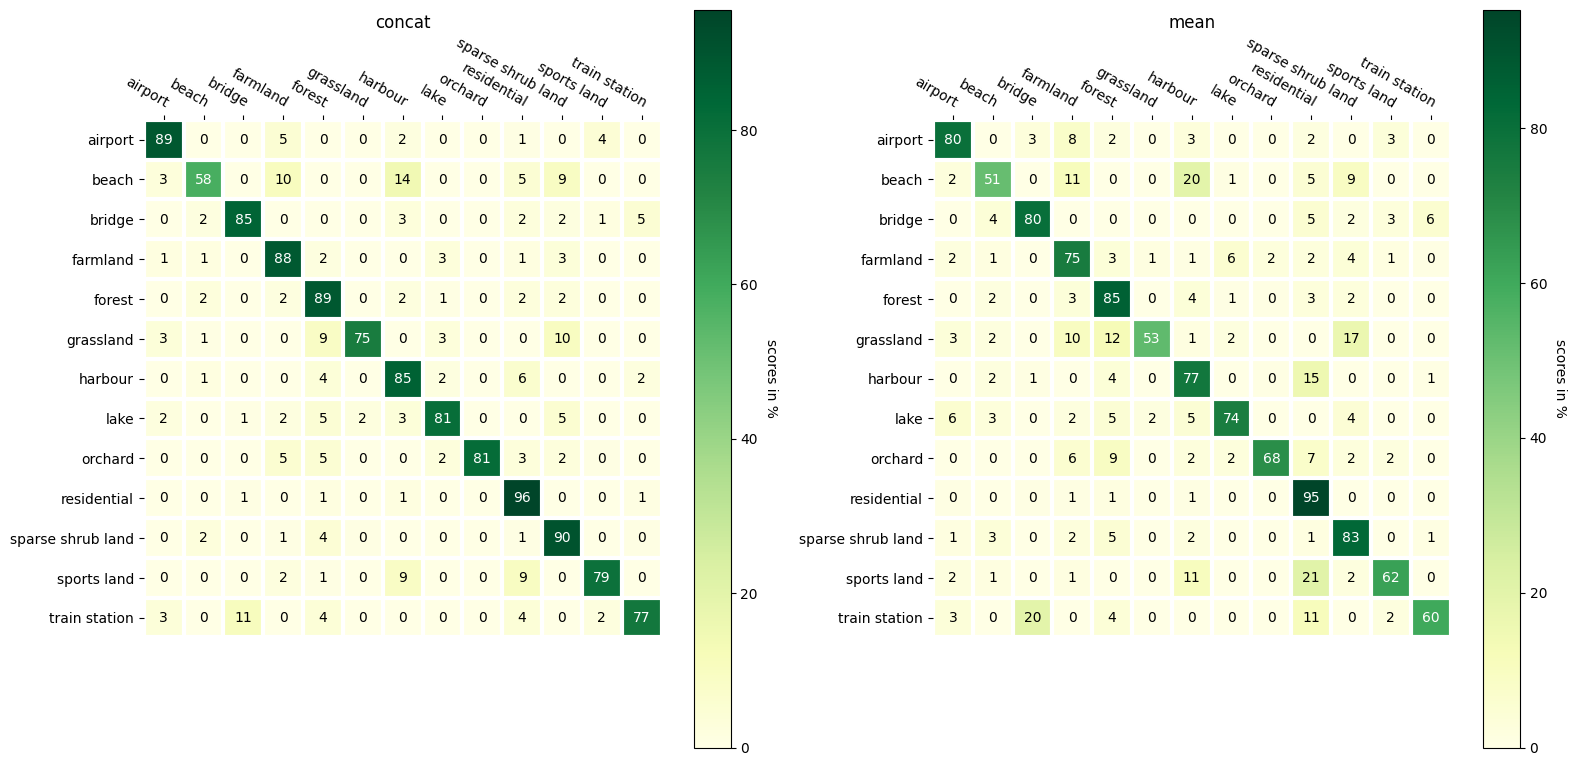

In [ ]:
print("--- plot confusion matrix to classes concat and mean ---")

fig = plt.figure(figsize=(16,8))
for idx in range(2):
  title,cf_values = list(dict_cf.items())[::-1][idx]
  count_arr = np.sum(cf_values,axis=1)[:,np.newaxis]
  percentual_cf_values = np.divide(cf_values,count_arr)*100
  ax = plt.subplot(1,2,idx+1)
  im, cbar = heatmap(percentual_cf_values,idx2lbl.values(),idx2lbl.values(), ax=ax,
                   cmap="YlGn", cbarlabel="scores in %")

  texts = annotate_heatmap(im,valfmt="{x:.0f}")
  plt.title(title)



plt.tight_layout()

In [ ]:
# SAVE FIGURE

figure_name = "confusion_matrix_mean_concat.png"

if Path(f"figures/{type_model.value}").is_dir():
  save_at = f"./figures/{type_model.value}/{figure_name}"
else:
  Path(f"figures/{type_model.value}").mkdir()
  save_at = f"./figures/{type_model.value}/{figure_name}"


fig.savefig(save_at)

#clears the plt
plt.show()

## 4.4 - Move figure and tables files to drive

In [ ]:
!cp -r ./figures/vit_base_32patch_latest ../drive/MyDrive/envs/sounding_earth/sounding_earth_vit/figures/vit_base_32patch_latest
!cp -r ./tables/vit_base_32patch_latest ../drive/MyDrive/envs/sounding_earth/sounding_earth_vit/tables/vit_base_32patch_latest